<a href="https://colab.research.google.com/github/nhanhd06/Book_Recommendation/blob/main/Data_Prepocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Book-Crossing Recommendation System**

**Aim**: Build a recommendation engine using the Book-Crossing dataset, which includes book, user and ratings dataset

We will use the method of collaborative filtering to build the system. **Collaborative Filtering** is try to search for those viewers/readers who have similar preference like you and offer products based on what his/her lookalike has chosen. To make that approch, we will use a method to find the distance between data points, in this case, are the book title, ratings, and other features. 

>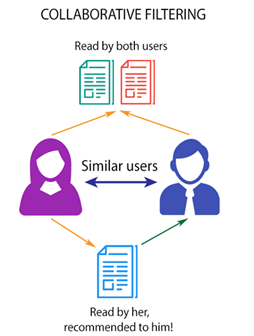

## **1. Data Preprocessing**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install kaggle

In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle as pickle
from sklearn import model_selection

**Import the dataset from kaggle**

In [3]:
file_share_link="https://drive.google.com/file/d/1M4yqyHPmR-EVXzyqeL1dVixkwuEhKpKD/view?usp=sharing"
file_id = file_share_link.split("/")
file_address = 'https://docs.google.com/uc?export=download&id=' + file_id[5]

In [18]:
! rm -rf .kaggle && mkdir .kaggle
! rm -rf kaggle.json && wget -O kaggle.json "$file_address" 
! mv kaggle.json ~/.kaggle/ 
! chmod 600 /root/.kaggle/kaggle.json
! rm -rf books-dataset.zip && kaggle datasets download saurabhbagchi/books-dataset
! rm -rf books.csv ratings.csv users.csv && unzip  -j books-dataset.zip

--2021-12-05 15:41:28--  https://docs.google.com/uc?export=download&id=1M4yqyHPmR-EVXzyqeL1dVixkwuEhKpKD
Resolving docs.google.com (docs.google.com)... 142.250.188.46, 2607:f8b0:4004:835::200e
Connecting to docs.google.com (docs.google.com)|142.250.188.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s4h8dkub7uebi2dd6ilk5njqc3h7adra/1638718875000/15672033725657311753/*/1M4yqyHPmR-EVXzyqeL1dVixkwuEhKpKD?e=download [following]
--2021-12-05 15:41:28--  https://doc-0o-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s4h8dkub7uebi2dd6ilk5njqc3h7adra/1638718875000/15672033725657311753/*/1M4yqyHPmR-EVXzyqeL1dVixkwuEhKpKD?e=download
Resolving doc-0o-5c-docs.googleusercontent.com (doc-0o-5c-docs.googleusercontent.com)... 172.217.1.193, 2607:f8b0:4004:801::2001
Connecting to doc-0o-5c-docs.googleusercontent.com (doc-0o-5c-docs.google

In [19]:
books = pd.read_csv('books.csv', sep=';', error_bad_lines=False, encoding="latin-1" )
users = pd.read_csv('users.csv', sep=';', error_bad_lines=False, encoding="latin-1" )
ratings = pd.read_csv('ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1" )

# If you get an error on loading the datasets, try to run the line 6(code) twice.

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:27

**Checking data output and shape**

In [20]:
print('Books Data Summary: ', books.shape)
print('Users Data Summary: ', users.shape)
print('Ratings Data Summary: ', ratings.shape)

Books Data Summary:  (271360, 8)
Users Data Summary:  (278858, 3)
Ratings Data Summary:  (1149780, 3)


### **Preprocessing Users Data**

Check user data => Looks like location is combined with full address

In [21]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [22]:
users.dtypes

User-ID       int64
Location     object
Age         float64
dtype: object

***First, inspect User-ID Field***

Inspect to see if there is any duplicated User-ID => Looks like none

In [23]:
unique_users = users['User-ID'].nunique()
all_users = users['User-ID'].count()
print("User-ID Unique Number: " + str(unique_users))
print("All User-ID Number: " + str(all_users))

User-ID Unique Number: 278858
All User-ID Number: 278858


***Next, inspect Location Field***

Break Location Field into City, State, and Country and display data

In [24]:
# Split Location
data_expand = users['Location'].str.split(',', 2, expand=True)
data_expand.columns = ['City', 'State', 'Country']
users = users.join(data_expand)
users = users.drop(['Location'], axis=1)
users.head()

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


Check the top 10 cities with most amount of users => Looked like London is the most

In [25]:
top_cities = users['City'].value_counts()[:10]
print("Top 10 Cities With Most Users:")
print(top_cities)

Top 10 Cities With Most Users:
london       4105
barcelona    2664
toronto      2342
madrid       1933
sydney       1884
portland     1869
melbourne    1863
vancouver    1699
chicago      1566
seattle      1541
Name: City, dtype: int64


In [26]:
# Check top 10 countries with most amount of users 
top_countries = users['Country'].value_counts()[:10]
print("Top 10 Countries With Most Users:")
print(top_countries)

Top 10 Countries With Most Users:
 usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: Country, dtype: int64


It is interesting that City London has the most but USA is taking the lead in this field




It looks like empty in Country Field has a lot = 4561 => Go ahead and replace its value with Nan instead

In [27]:
#users['Country'].replace('', np.nan, inplace=True)

***Next, inspect Age Field***

Check Age Column Values => Some of values are not correct like 244 which is too high for human age

In [28]:
users['Age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

Check the entire age column => Looks like we did have the range above 100 years old a lot up to 244

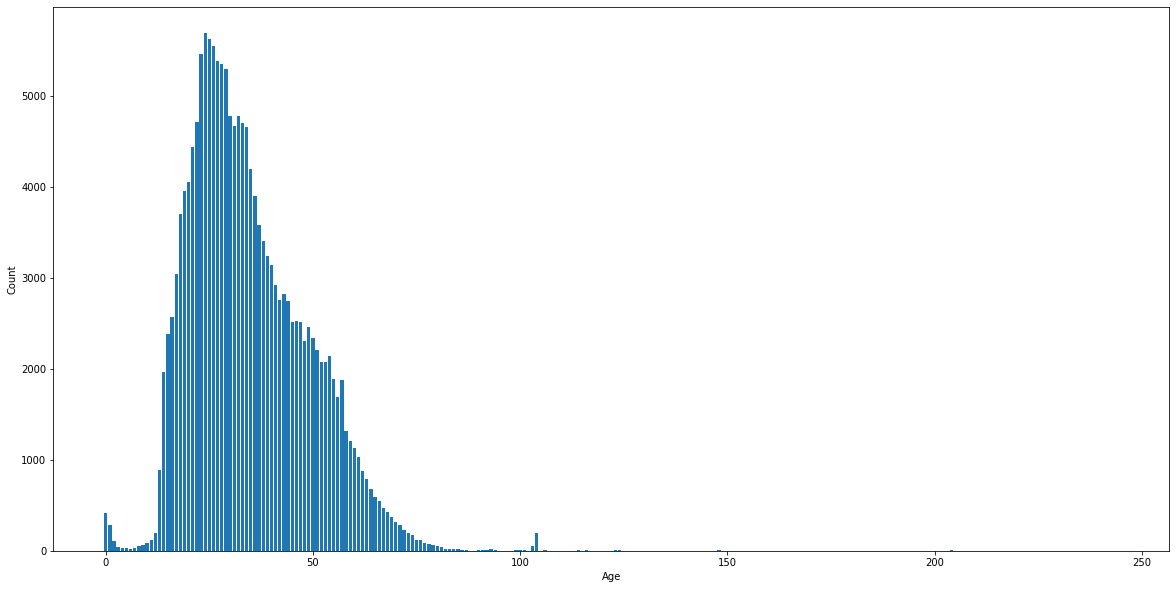

In [29]:
data = users['Age'].value_counts()
plt.figure(figsize=(20, 10))
plt.bar(data.index, data.values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Making Histogram to show data distribution => Most customer are between 10 - 80

In [30]:
users['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

It is best to adjust Users Dataset to be associated with 7 < Age < 80 only => Considered children - adults age

In [31]:
users.loc[(users['Age']<7) | (users['Age']>80), 'Age'] = np.nan
users['Age'].describe()

count    166584.000000
mean         34.686128
std          13.503880
min           7.000000
25%          24.000000
50%          32.000000
75%          44.000000
max          80.000000
Name: Age, dtype: float64

Calculate how many null values in Age Column and calculate the percentage it takes the entire dataset => It is a lot with 67 % => Decided not to drop instead

In [32]:
null_age_count = users['Age'].isnull().sum()
total_age_count = users['Age'].count()
total_percent = (null_age_count/total_age_count) * 100
total_percent
print(f'Total percent of null value in Users Data: {total_percent:.2f}%')

Total percent of null value in Users Data: 67.40%


In [33]:
# save the progress
users.to_csv('users_prepocessing.csv')

### **Preprocessing Books Data**

In [34]:
books.tail()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...
271359,0767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...,http://images.amazon.com/images/P/0767409752.0...


The dataset 'books' has following features:
ISBN, Book Title, Book author, year of publication, publisher, image URL with different sizes.

In [35]:
books.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

***First, inspect ISBN Field***

Check for duplicated values => Looks like there is none

In [36]:
unique_ISBN = books.ISBN.nunique()
all_ISBN = books.ISBN.count()
print("ISBN Unique Number: " + str(unique_ISBN))
print("All ISBN Number: " + str(all_ISBN))

ISBN Unique Number: 271360
All ISBN Number: 271360


***Next, inspect Book Title Field***

Check whether it has empty field or not => There is none

In [37]:
empty_string_title = books[books['Book-Title'] == '']
empty_string_title.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


Check to see if there is duplicated values in books or not => Looks like a lot

In [38]:
top_book_titles = books['Book-Title'].value_counts()[:10]
print("Top Duplicated Book Title:")
print(top_book_titles)

Top Duplicated Book Title:
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
Adventures of Huckleberry Finn    20
The Secret Garden                 20
Dracula                           20
Jane Eyre                         19
The Night Before Christmas        18
Pride and Prejudice               18
Great Expectations                17
Name: Book-Title, dtype: int64


Check out the book title with above least amount of duplicated values - Masquerade => As it turned out, this books has a lot of different version being published different year => Hence explained why there are many different ISBNs

In [39]:
display(books[books['Book-Title']=='Masquerade'])

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
6665,042516019X,Masquerade,Gayle Lynds,1997,Berkley Publishing Group,http://images.amazon.com/images/P/042516019X.0...,http://images.amazon.com/images/P/042516019X.0...,http://images.amazon.com/images/P/042516019X.0...
9973,0316171476,Masquerade,Janet Dailey,1991,"Little, Brown",http://images.amazon.com/images/P/0316171476.0...,http://images.amazon.com/images/P/0316171476.0...,http://images.amazon.com/images/P/0316171476.0...
32792,080523747X,Masquerade,Kit Williams,1984,Schocken Books,http://images.amazon.com/images/P/080523747X.0...,http://images.amazon.com/images/P/080523747X.0...,http://images.amazon.com/images/P/080523747X.0...
34258,0821728334,Masquerade,Lowell Cauffiel,1989,Zebra Books,http://images.amazon.com/images/P/0821728334.0...,http://images.amazon.com/images/P/0821728334.0...,http://images.amazon.com/images/P/0821728334.0...
43592,0897330137,Masquerade,Sarah Hobson,1982,Academy Chicago Publishers,http://images.amazon.com/images/P/0897330137.0...,http://images.amazon.com/images/P/0897330137.0...,http://images.amazon.com/images/P/0897330137.0...
47422,0425117405,Masquerade,Serena Richards,1989,Berkley Pub Group,http://images.amazon.com/images/P/0425117405.0...,http://images.amazon.com/images/P/0425117405.0...,http://images.amazon.com/images/P/0425117405.0...
51707,0345366204,Masquerade,William X. Kienzle,1991,Fawcett Books,http://images.amazon.com/images/P/0345366204.0...,http://images.amazon.com/images/P/0345366204.0...,http://images.amazon.com/images/P/0345366204.0...
53579,0786015047,Masquerade,Lowell Cauffiel,2001,Pinnacle Books (Mm),http://images.amazon.com/images/P/0786015047.0...,http://images.amazon.com/images/P/0786015047.0...,http://images.amazon.com/images/P/0786015047.0...
82989,0312969899,Masquerade,Walter Satterthwait,1999,St. Martin's Paperbacks,http://images.amazon.com/images/P/0312969899.0...,http://images.amazon.com/images/P/0312969899.0...,http://images.amazon.com/images/P/0312969899.0...
85620,0786004681,Masquerade,Lowell Cauffiel,1997,Pinnacle Books,http://images.amazon.com/images/P/0786004681.0...,http://images.amazon.com/images/P/0786004681.0...,http://images.amazon.com/images/P/0786004681.0...


It is best to keep those duplicated Book Title values since books would often have some changes in translation and appearance => Would definetely affect rating scale as well

***Next, inspect Book Author Field***

Check whether it has empty field or not => There is none

In [40]:
empty_string_author = books[books['Book-Author'] == '']
empty_string_author.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


Check the top 10 authors of books in this dataset

In [41]:
top_book_authors = books['Book-Author'].value_counts()[:10]
print("Top 10 Authors with Most Entries:")
print(top_book_authors)

Top 10 Authors with Most Entries:
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: Book-Author, dtype: int64


***Next, inspect Year Of Publication Field***

Transform Year Of Publication from object to float type since the entire data contains only numbers

In [42]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce', downcast='signed')

Check Year Of Publication Field => Looks like 0 is existed

In [43]:
books['Year-Of-Publication'].describe()

count    271357.000000
mean       1959.760817
std         257.994226
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: Year-Of-Publication, dtype: float64

Replaced all rows of Year Of Publication with 0 with Nan since it is unknown and would not interference with any working algorithm


In [44]:
books.loc[books['Year-Of-Publication'] == 0] = np.nan

Check Year Of Publication Field again

In [45]:
books['Year-Of-Publication'].describe()

count    266739.000000
mean       1993.689772
std           8.325811
min        1376.000000
25%        1989.000000
50%        1996.000000
75%        2000.000000
max        2050.000000
Name: Year-Of-Publication, dtype: float64

Not sure how there is a boook with publish date with future years as indicated above it goes on until 2050 but it looks like this data set is wrong => Alice in Wonderland = 2030

In [46]:
future_books = books[books['Year-Of-Publication']>2021]
future_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
37487,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030.0,Aladdin,http://images.amazon.com/images/P/0671746103.0...,http://images.amazon.com/images/P/0671746103.0...,http://images.amazon.com/images/P/0671746103.0...
55676,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030.0,Aladdin,http://images.amazon.com/images/P/0671791990.0...,http://images.amazon.com/images/P/0671791990.0...,http://images.amazon.com/images/P/0671791990.0...
78168,0870449842,Crossing America,National Geographic Society,2030.0,National Geographic,http://images.amazon.com/images/P/0870449842.0...,http://images.amazon.com/images/P/0870449842.0...,http://images.amazon.com/images/P/0870449842.0...
80264,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050.0,Puffin Books,http://images.amazon.com/images/P/0140301690.0...,http://images.amazon.com/images/P/0140301690.0...,http://images.amazon.com/images/P/0140301690.0...
97826,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050.0,Penguin USA,http://images.amazon.com/images/P/0140201092.0...,http://images.amazon.com/images/P/0140201092.0...,http://images.amazon.com/images/P/0140201092.0...


Based on the above result, the minimum is too slow as well = 1376 and it is better to sort out book that is published after 1900 instead

In [47]:
old_books = books[books['Year-Of-Publication']<1900]
old_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806.0,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378.0,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897.0,Reprint Services Corp,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376.0,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


Deleted those ISBN Books not below 1900 and not above 2021

In [48]:
books = books.loc[~(books['ISBN'].isin(old_books['ISBN']))]
books = books.loc[~(books['ISBN'].isin(future_books['ISBN']))]
books['Year-Of-Publication'].describe()

count    266722.000000
mean       1993.693524
std           8.137847
min        1900.000000
25%        1989.000000
50%        1996.000000
75%        2000.000000
max        2021.000000
Name: Year-Of-Publication, dtype: float64

In [49]:
books.shape

(271343, 8)

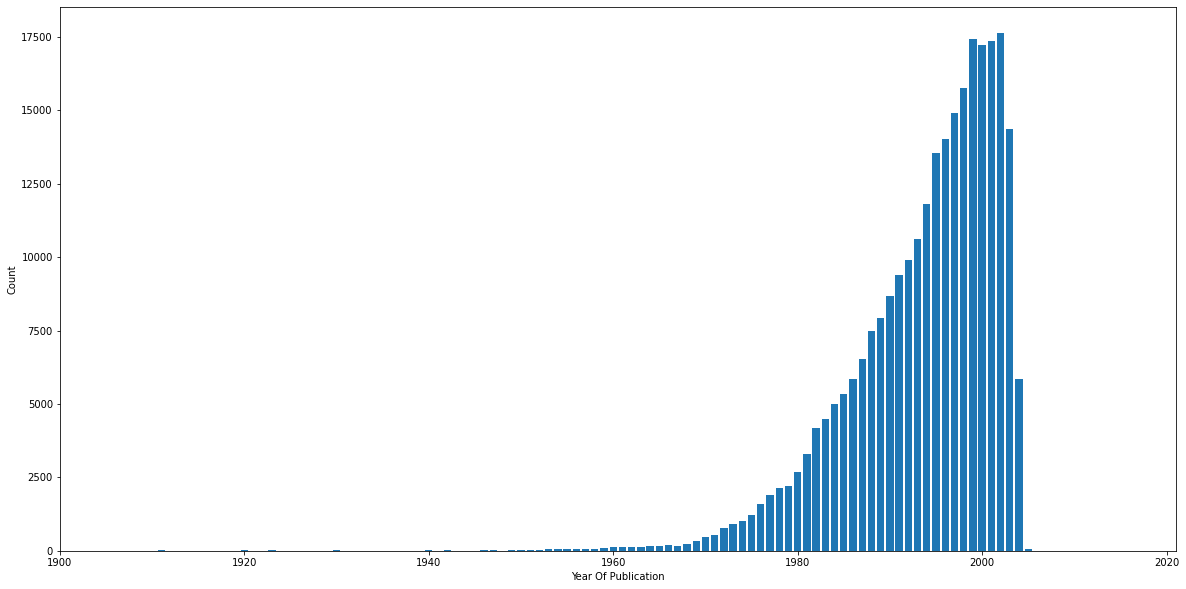

In [50]:
data = books['Year-Of-Publication'].value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.bar(data.index, data.values)
plt.xlim([1900, 2021])
plt.xlabel('Year Of Publication')
plt.ylabel('Count')
plt.show()

Draw the graph for Year Of Publication and it looks like mot book are between 1980 to 2005 

***Next, inspect Publisher Field***

Check whether it has empty field or not => There is none

In [51]:
empty_publishers = books[books['Publisher'] == '']
empty_publishers.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [52]:
top_publishers = books.Publisher.value_counts()[:10]
print("Top 10 Publishers with Most Entries:")
print(top_publishers)

Top 10 Publishers with Most Entries:
Harlequin                   7535
Silhouette                  4220
Pocket                      3870
Ballantine Books            3764
Bantam Books                3642
Scholastic                  3157
Simon &amp; Schuster        2965
Penguin Books               2843
Berkley Publishing Group    2767
Penguin USA                 2714
Name: Publisher, dtype: int64


***Next, inspect Image-URL-S, Image-URL-M, Image-URL-L***

It is better to drop these fields since there is no need

In [53]:
books = books.drop(['Image-URL-S'], axis=1)
books = books.drop(['Image-URL-M'], axis=1)
books = books.drop(['Image-URL-L'], axis=1)

In [54]:
# save the progress
books.to_csv('books_preprocessing.csv')

### **Preprocessing Ratings Data**

In [55]:
ratings.tail()

,User-ID,ISBN,Book-Rating
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10
1149779,276723,05162443314,8


In [56]:
ratings.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

***First, inspect User-ID Field***

Check if there is any null value => Looks like none

In [57]:
empty_User_ID = ratings[ratings['User-ID'] == '']
empty_User_ID.head()

,User-ID,ISBN,Book-Rating


***Next, inspect ISBN Field***

Check 10 User ID with most ratings reviews on ISBN Field => Looks like user - 11676 has the huge ammount compared to the rest

In [58]:
top_users = ratings.groupby('User-ID')['ISBN'].count().sort_values(ascending=False)
print("Top 10 Users with most ratings: ")
top_users[:10]

Top 10 Users with most ratings: 


User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: ISBN, dtype: int64

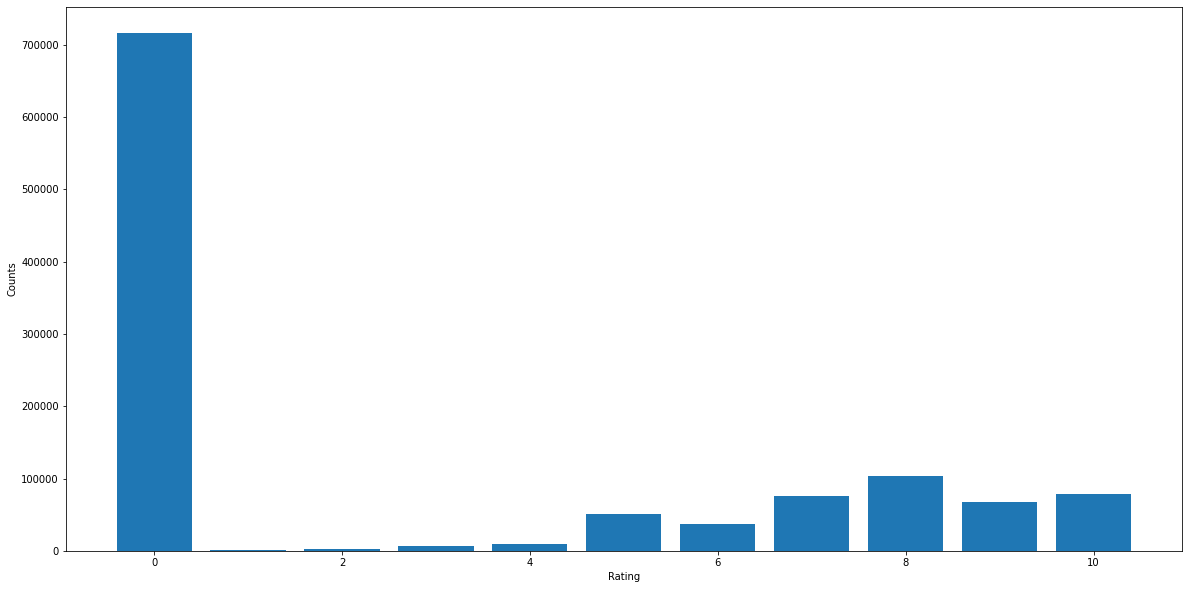

In [59]:
# Check and see the distribution of ratings
rtg = ratings['Book-Rating'].value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show()

Looks like there are a lot of zero values => Not reviewed and the rating review is supposed to start from 1 to 10 => Explained why the above users have a lot of amounts as well 

It is best to drop those zero values since it doesn't serve anything and takes a lot of space as well => Check again if zero is still existed or not on histogram

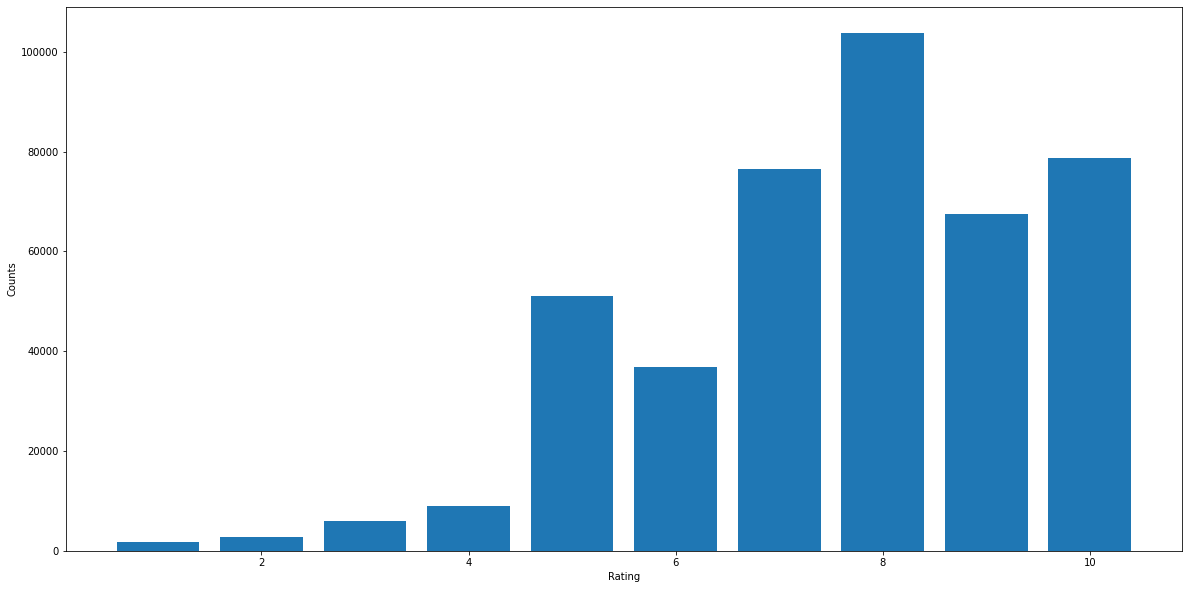

In [60]:
ratings = ratings[ratings['Book-Rating'] != 0]
rtg = ratings['Book-Rating'].value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.show()

***Next, inspect Book Rating Field***

Check Book Rating Column => Realize there is 0 - User has not rated the book yet 

In [61]:
ratings['Book-Rating'].describe()

count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64

Checked how many Book Rating data has 0 => More than half => It is better to drop those and only keep the ones with 1 to 10 rating scale

In [62]:
with_0_ratings = ratings['Book-Rating'].count()
without_0_ratings = ratings[ratings['Book-Rating'] != 0]['Book-Rating'].count()
print("Total Count - Book Rating With Zero: ", with_0_ratings)
print("Total Count - Book Rating Without Zero: ", without_0_ratings)

Total Count - Book Rating With Zero:  433671
Total Count - Book Rating Without Zero:  433671


Graph Rating Data Set => It looks like most rating is above 5 - 10

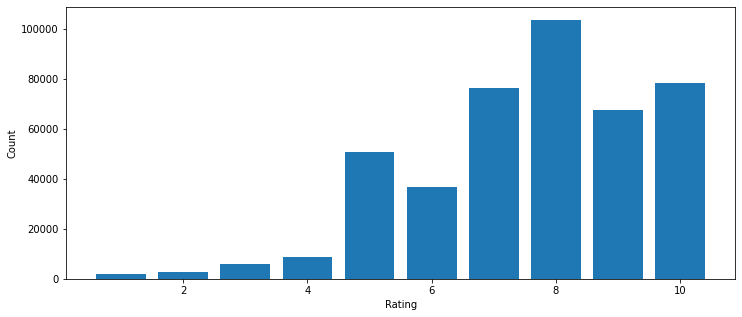

In [63]:
ratings = ratings[ratings['Book-Rating'] != 0]
data = ratings['Book-Rating'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(data.index, data.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [64]:
# save the progress
ratings.to_csv('ratings_preprocessing.csv')

### **Merge datasets - Users, Books, and Ratings**

In [65]:
path = '/content/users_prepocessing.csv'

users = pd.read_csv(path, delimiter=',', index_col=0)

In [66]:
path = '/content/books_preprocessing.csv'

books = pd.read_csv(path, delimiter=',', index_col=0)

In [67]:
path = '/content/ratings_preprocessing.csv'

ratings = pd.read_csv(path, delimiter=',', index_col=0)

In [68]:
# Check both books, users and ratings data size
print(f'Books Dataset Size: {len(books)}')
print(f'Ratings Dataset Size: {len(ratings)}')
print(f'Users Dataset Size: {len(users)}')

Books Dataset Size: 271343
Ratings Dataset Size: 433671
Users Dataset Size: 278858


In [69]:
print("user dataset:", users.columns)
print("ratings dataset:", ratings.columns)
print("books dataset:", books.columns)

user dataset: Index(['User-ID', 'Age', 'City', 'State', 'Country'], dtype='object')
ratings dataset: Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')
books dataset: Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Publisher'],
      dtype='object')


In [70]:
user_with_ratings = pd.merge(ratings, users, on='User-ID', how='inner')
user_with_ratings.tail(1)

,User-ID,ISBN,Book-Rating,Age,City,State,Country
433670,276723,05162443314,8,12.0,san antonio,texas,usa


In [71]:
data = pd.merge(user_with_ratings, books, on='ISBN', how='inner')
data.tail(1)

,User-ID,ISBN,Book-Rating,Age,City,State,Country,Book-Title,Book-Author,Year-Of-Publication,Publisher
378031,276704,0806917695,5,NaN,cedar park,texas,usa,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing


In [72]:
data.rename(columns={'Book-Rating':'book_rating', 'User-ID':'user_id', 'Book-Title':'book_title',
                     'Book-Author':'book_author','Year-Of-Publication':'year_of_publication'}, inplace=True)
data.tail(1)

,user_id,ISBN,book_rating,Age,City,State,Country,book_title,book_author,year_of_publication,Publisher
378031,276704,0806917695,5,NaN,cedar park,texas,usa,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing


In [73]:
data.isnull().sum()

user_id                     0
ISBN                        0
book_rating                 0
Age                    114619
City                     8435
State                     412
Country                 10350
book_title                  0
book_author                 1
year_of_publication         1
Publisher                   2
dtype: int64

In [74]:
# since there is few NaN values in some features; it's better to remove them
data = data.dropna(how='any', subset=['book_author', 'year_of_publication', 'Publisher'])
data.isnull().sum()

user_id                     0
ISBN                        0
book_rating                 0
Age                    114619
City                     8435
State                     412
Country                 10350
book_title                  0
book_author                 0
year_of_publication         0
Publisher                   0
dtype: int64

I will keep this dataframe since features 'Age', 'City', 'State', and 'Country' with missing values does not effect the further analysis.

In [75]:
data.to_csv('merged_data.csv')

## **2. Exploratory Data Analysis and Visualization**

In [183]:
path = '/content/merged_data.csv'

data = pd.read_csv(path, delimiter=',', index_col=0)

In [184]:
data.tail(5)

,user_id,ISBN,book_rating,Age,City,State,Country,book_title,book_author,year_of_publication,Publisher
378027,276688,0425156737,2,NaN,fort lee,new jersey,usa,Graven Images,Jane Waterhouse,1997.0,Berkley Publishing Group
378028,276688,0671563149,6,NaN,fort lee,new jersey,usa,MUDDY WATER (Peter Bartholomew Mysteries),Sally Gunning,1997.0,Pocket
378029,276688,1575660792,7,NaN,fort lee,new jersey,usa,Gray Matter,Shirley Kennett,1996.0,Kensington Publishing Corporation
378030,276704,0380796155,5,NaN,cedar park,texas,usa,White Abacus,Damien Broderick,1998.0,Eos
378031,276704,0806917695,5,NaN,cedar park,texas,usa,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing


In [186]:
rating_count = pd.DataFrame(data.groupby('ISBN')['book_rating'].count())
rating_count = rating_count.rename(columns={'book_rating': 'rating_count'})
rating_count.sort_values('rating_count', ascending=False).head(5)

,rating_count
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
0060928336,320


In [187]:
# get the top 20 books with highest book rating count
rating_count_top = rating_count.sort_values('rating_count', ascending=False).head(20)
rating_count_top = pd.merge(rating_count_top, books, on='ISBN', how='inner')

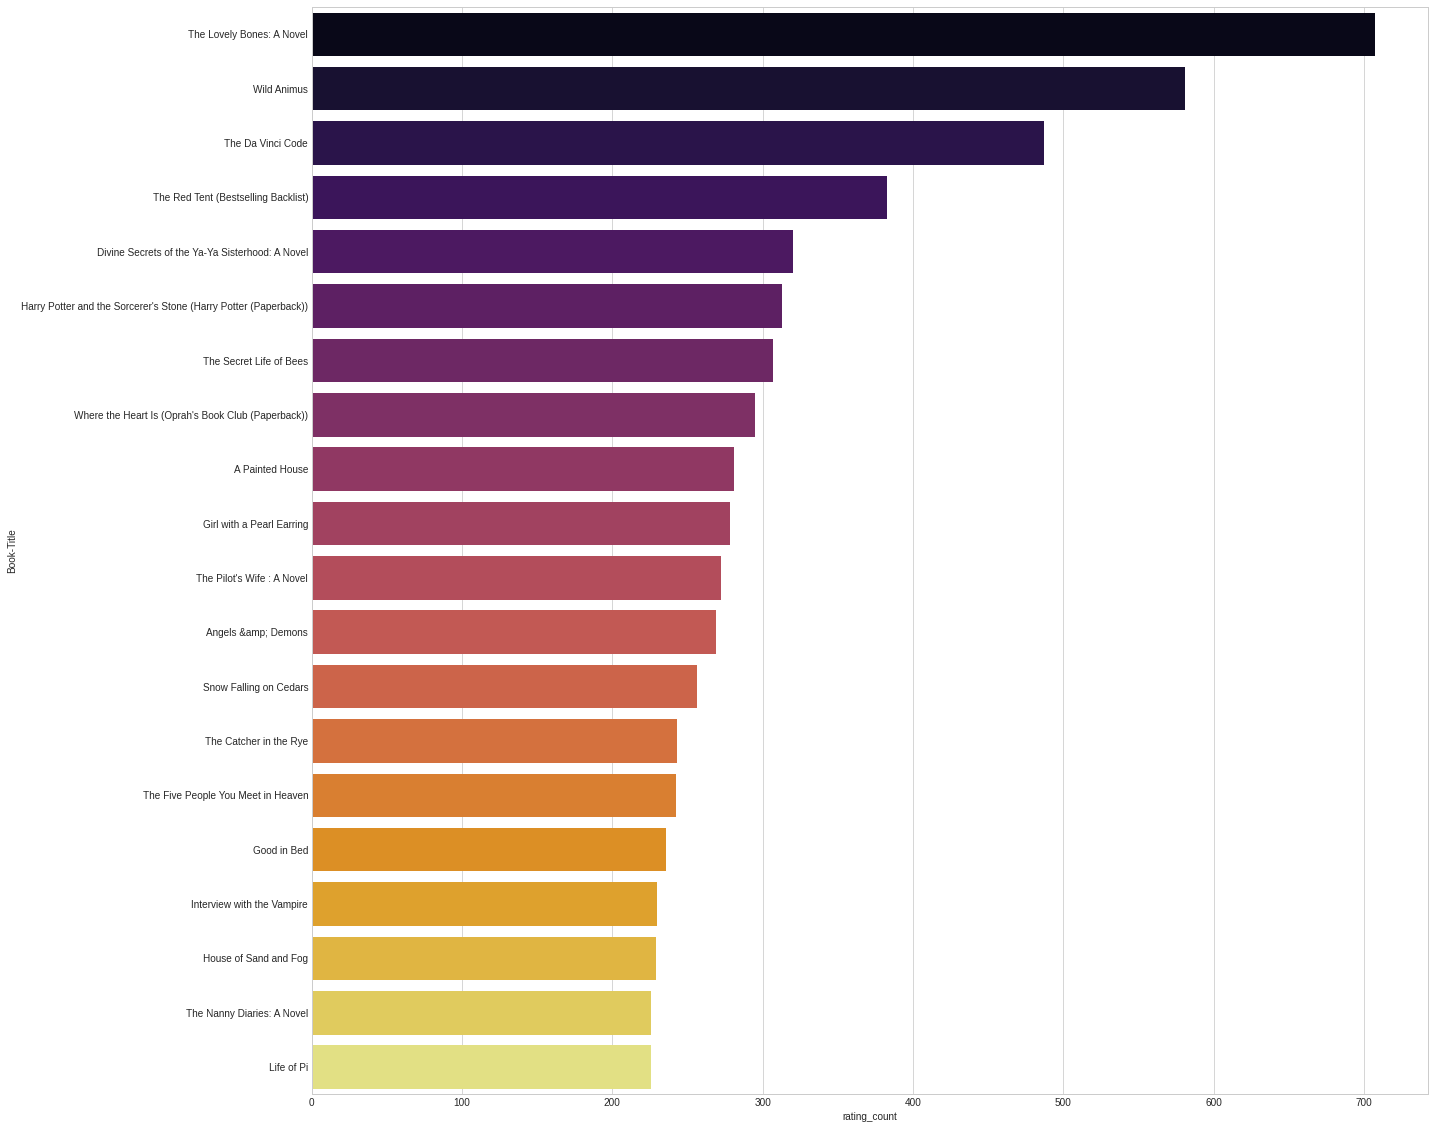

In [188]:
# show the top 20 books(name) with highest book rating count
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,20))
sns.barplot(x="rating_count", y="Book-Title", data=rating_count_top, palette='inferno')

--------------------------

In [189]:
average_rating = pd.DataFrame(data.groupby('ISBN')['book_rating'].mean())
average_rating = average_rating.rename(columns={'book_rating': 'rating_average'})
average_rating.sort_values('rating_average', ascending=False).head(5)

,rating_average
ISBN,
0553261916,10.0
0870540890,10.0
1843330644,10.0
0870441590,10.0
0870409727,10.0


In [190]:
# get the top 20 books with highest book average rating
average_rating_top = average_rating.sort_values('rating_average', ascending=False).head(20)
average_rating_top = pd.merge(average_rating_top, books, on='ISBN', how='inner')

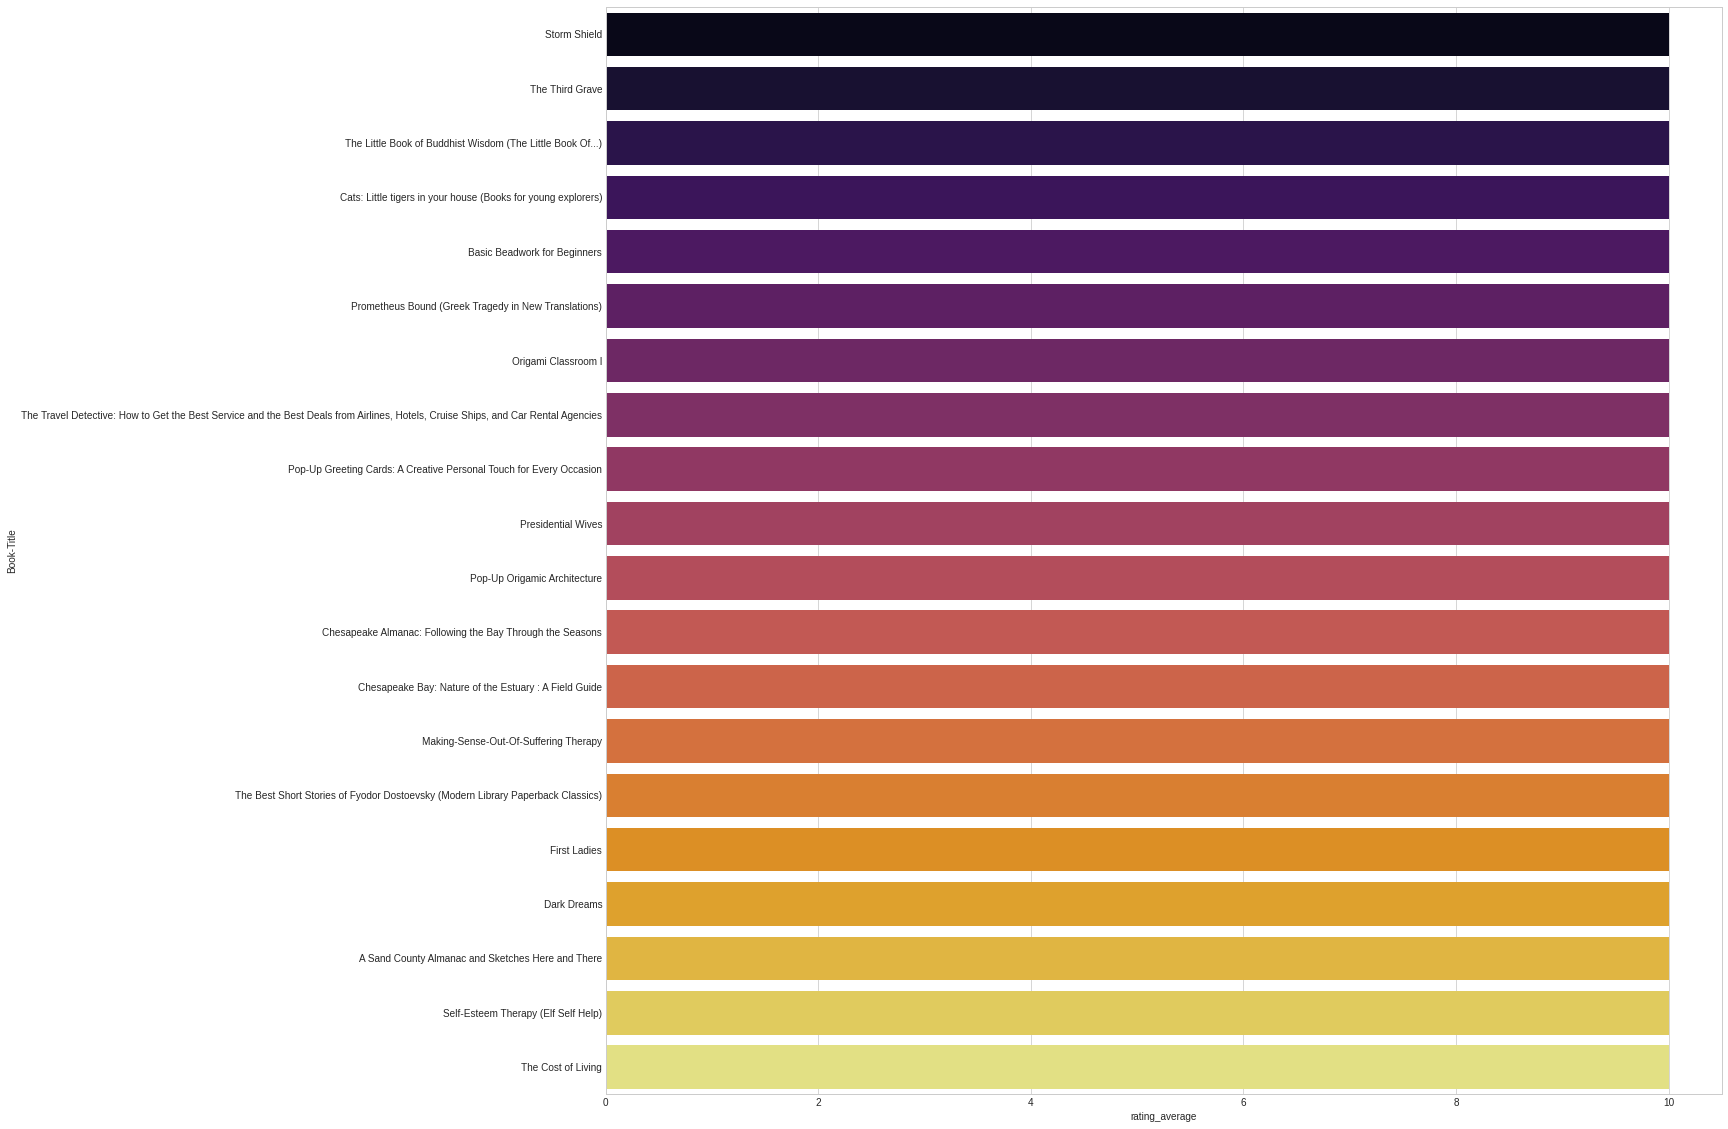

In [191]:
# show the top 20 books(name) with highest average rating
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,20))
sns.barplot(x="rating_average", y="Book-Title", data=average_rating_top, palette='inferno')

It seems something wrong about this graph. All the books average are high. This happened because the dataset includes those data with highest rating but very low rating counts. So, I need to remove those books with lowest counts first.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'average rating')

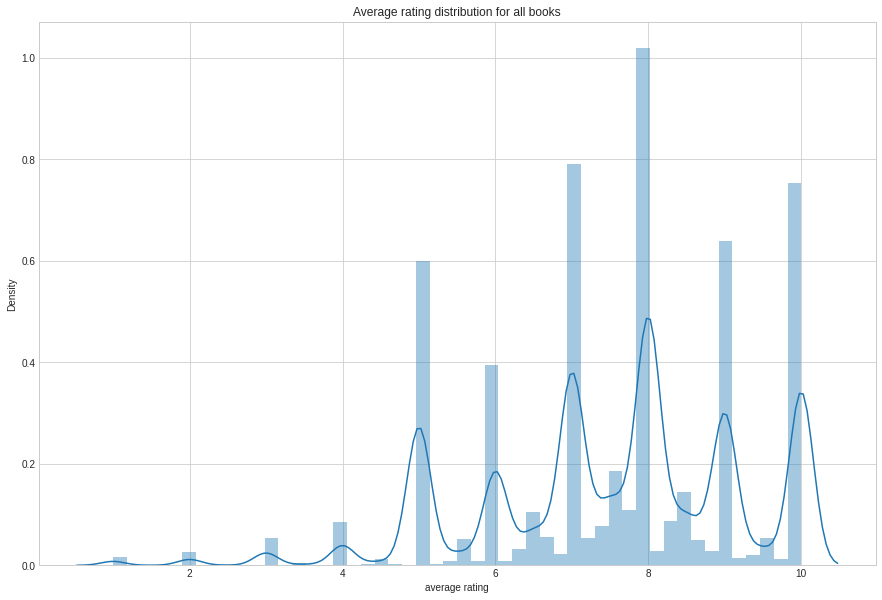

In [192]:
# plot the average distribution of rating counts
fig, ax= plt.subplots(figsize=[15,10])

sns.distplot(average_rating.values, ax=ax)
ax.set_title('Average rating distribution for all books')
ax.set_xlabel('average rating')

By looking the graph, there is some books average 10/10 in rating.

In [193]:
data.tail(1)

,user_id,ISBN,book_rating,Age,City,State,Country,book_title,book_author,year_of_publication,Publisher
378031,276704,0806917695,5,NaN,cedar park,texas,usa,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing


In [194]:
# find those authors who get pick the most by users
authors_count = data['book_author'].value_counts().head(10)
#authors_count

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Total times')

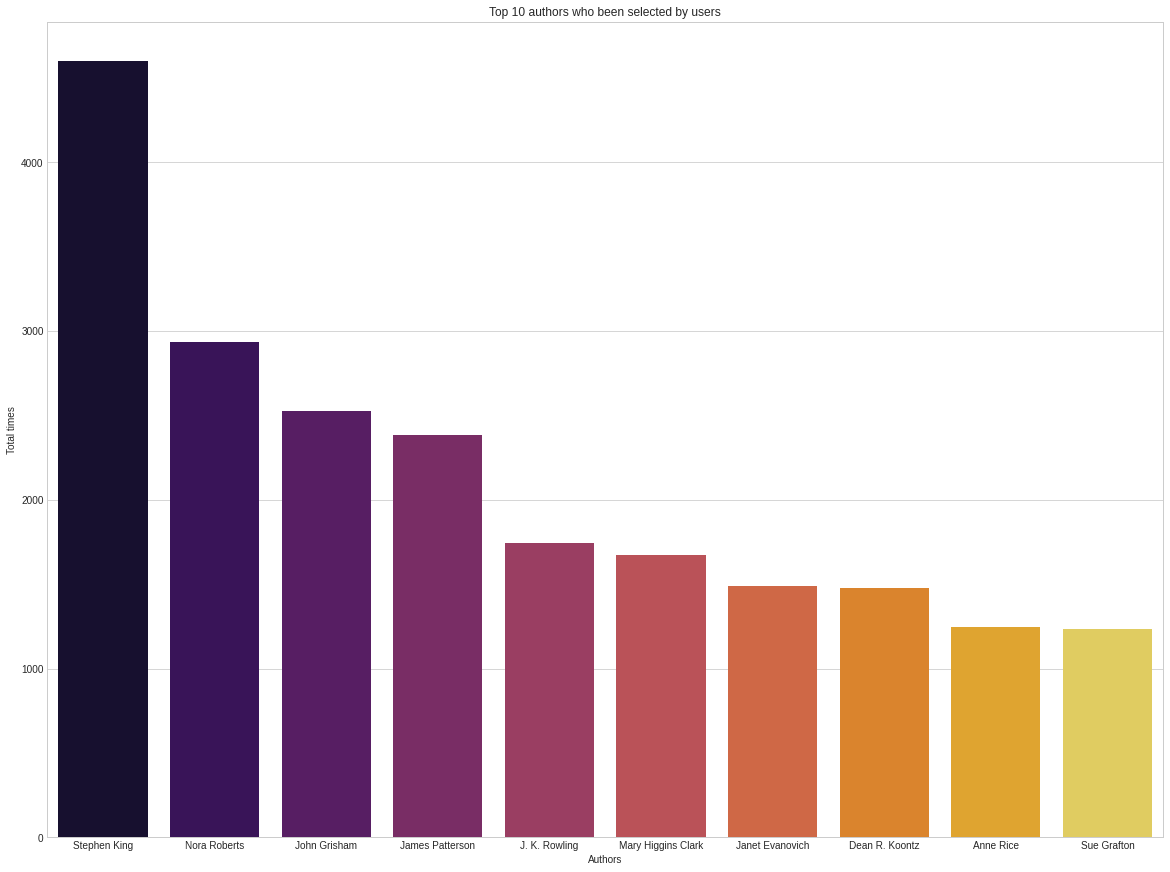

In [195]:
plt.figure(figsize=(20,15))
ax=sns.barplot(authors_count.index, authors_count.values, palette='inferno')
ax.set_title("Top 10 authors who been selected by users")
ax.set_xlabel("Authors")
ax.set_ylabel("Total times")

-------------------

In [197]:
data.tail(1)

,user_id,ISBN,book_rating,Age,City,State,Country,book_title,book_author,year_of_publication,Publisher
378031,276704,0806917695,5,NaN,cedar park,texas,usa,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing


In [208]:
# Check average highest ratings with a minimum number with more than 20 reviews
length = data['book_title'].value_counts()
mean_ratings = data[data['book_title'].isin(length[length>20].index)].groupby('book_title')['book_rating'].mean()
temp = mean_ratings.sort_values(ascending=False)[:10]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Ratings')

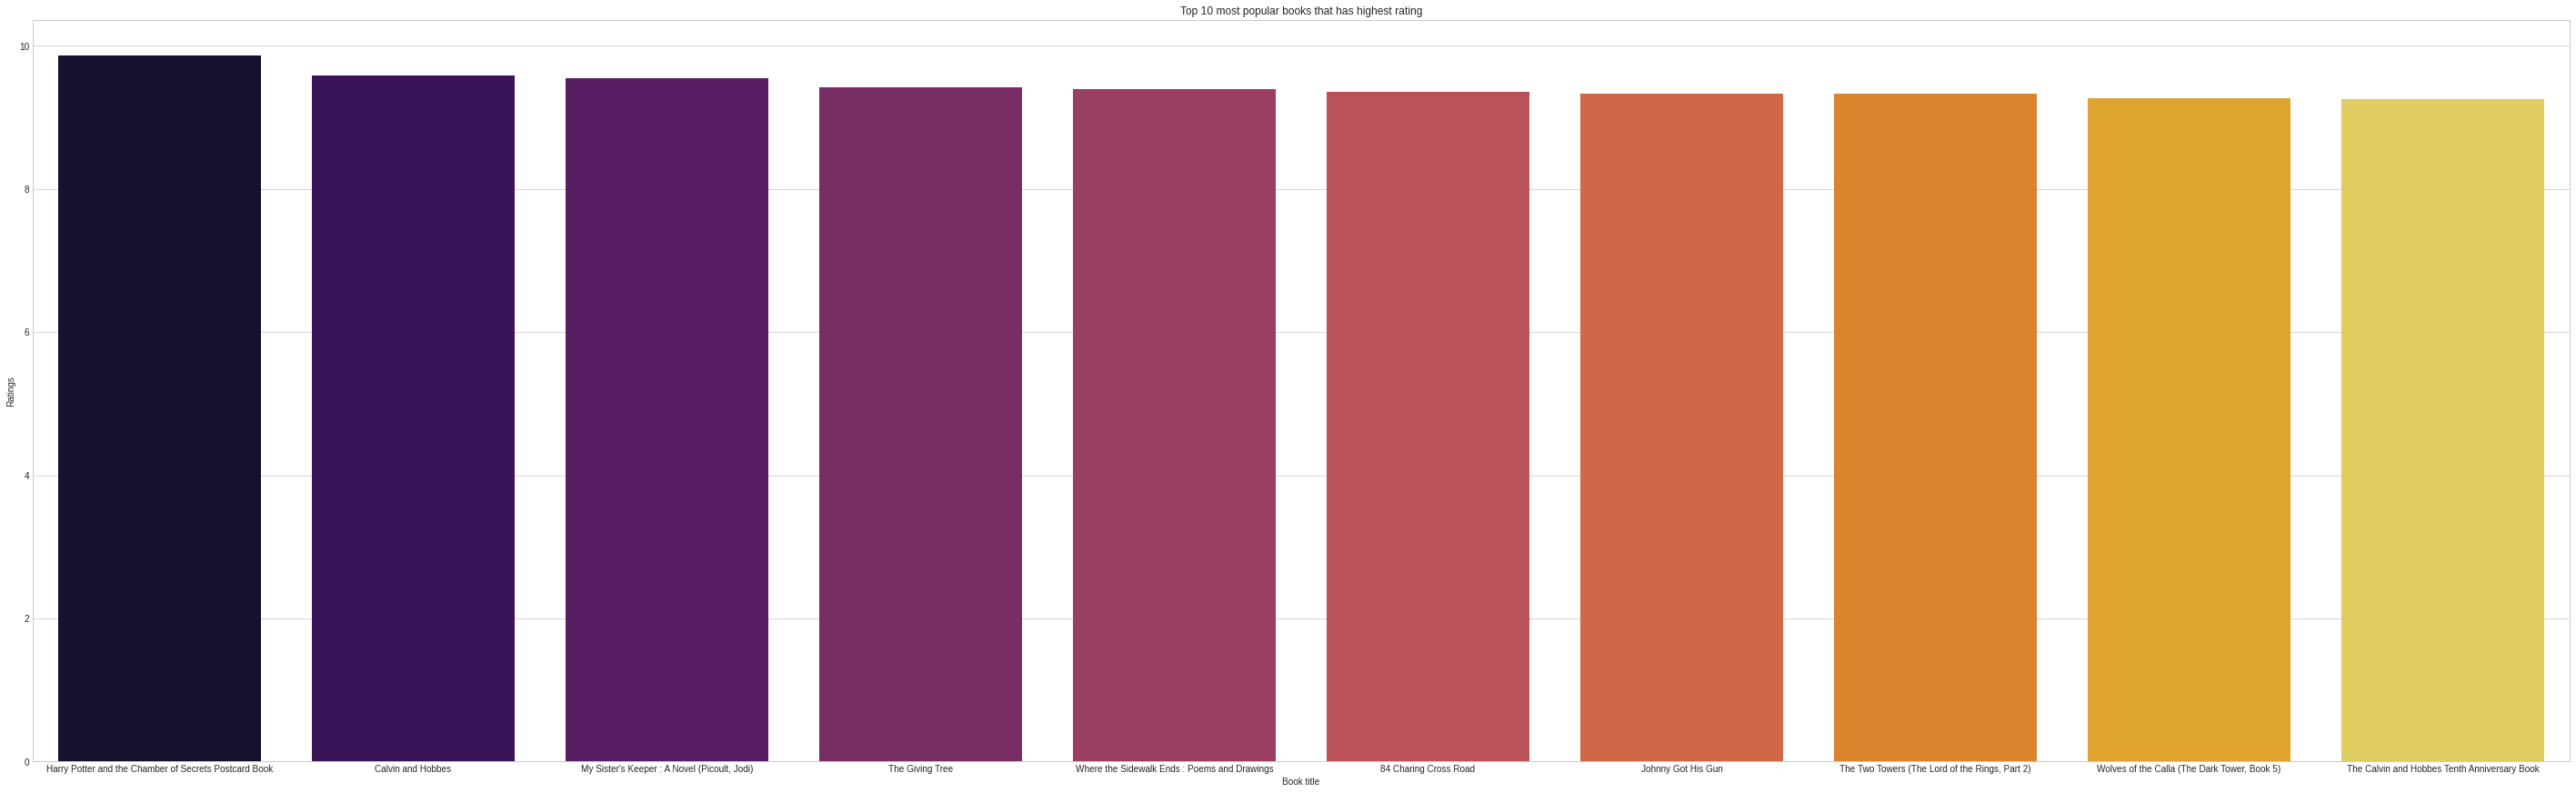

In [211]:
plt.figure(figsize=(50,15))
ax=sns.barplot(temp.index, temp.values, palette='inferno')
ax.set_title("Top 10 most popular books that has highest rating")
ax.set_xlabel("Book title")
ax.set_ylabel("Ratings")

# click the graph if you want to see it bigger

The output indicates the most popular books. This information is useful for selecting the right data to do further anylsis.

Check least ratings with a minimum number with more than 20 reviews => Looked like the lowest rating = 4 and these are not very weird book title

In [212]:
display(mean_ratings.sort_values(ascending=False)[-10:])

book_title
Filthy Rich                                5.960000
Mr. X                                      5.952381
The Klone and I: A High-Tech Love Story    5.666667
4 Blondes                                  5.653846
Killing Time                               5.517241
Naked Lunch                                5.458333
Isle of Dogs                               5.433962
Four Blondes                               5.393939
The Sexual Life of Catherine M.            4.913043
Wild Animus                                4.390706
Name: book_rating, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Ratings')

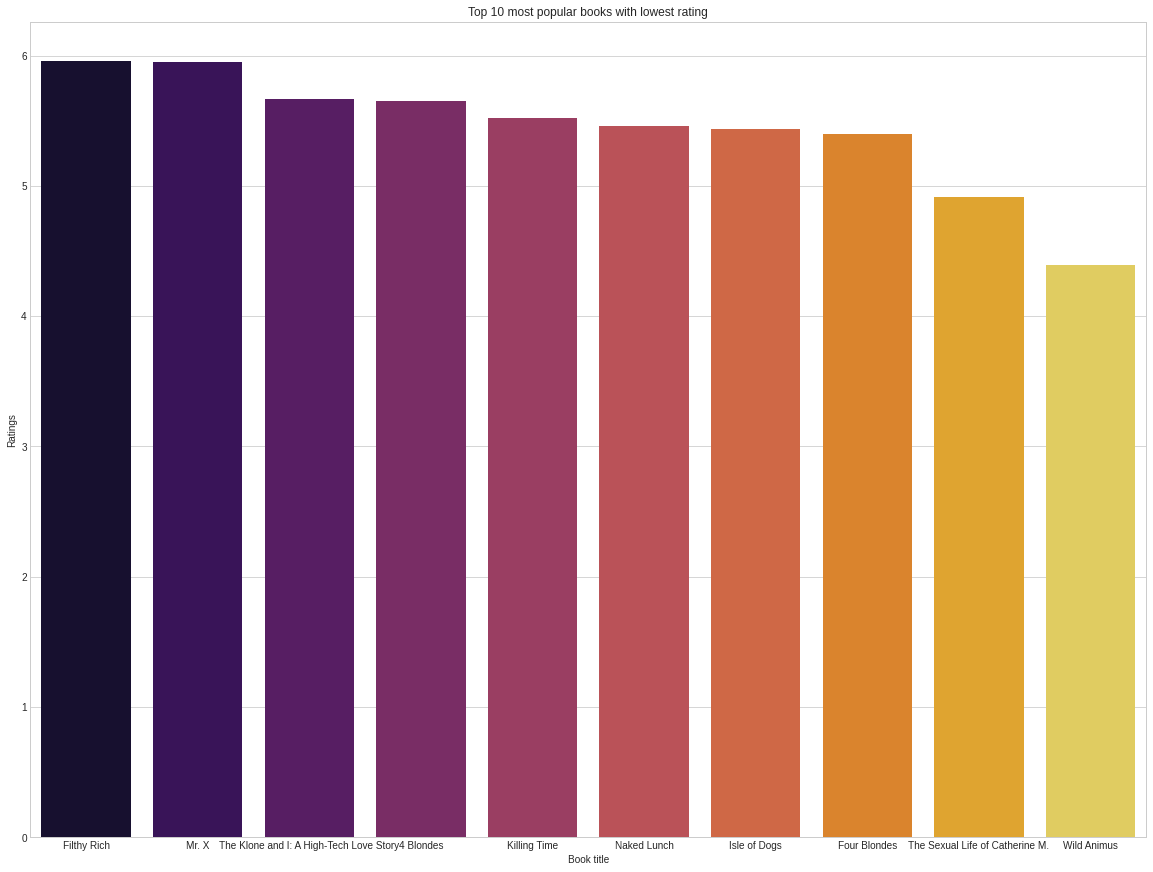

In [213]:
temp = mean_ratings.sort_values(ascending=False)[-10:]

plt.figure(figsize=(20,15))
ax=sns.barplot(temp.index, temp.values, palette='inferno')
ax.set_title("Top 10 most popular books with lowest rating")
ax.set_xlabel("Book title")
ax.set_ylabel("Ratings")

In [214]:
display(data.groupby('book_title')['ISBN'].nunique().sort_values(ascending=False)[:10])

book_title
The Secret Garden                 16
Selected Poems                    16
Dracula                           15
Adventures of Huckleberry Finn    15
Pride and Prejudice               14
Wuthering Heights                 14
Little Women                      13
Beloved                           13
Jane Eyre                         12
The Hobbit                        12
Name: ISBN, dtype: int64

Check again top 10 book titles with most ISBN Numbers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Update times')

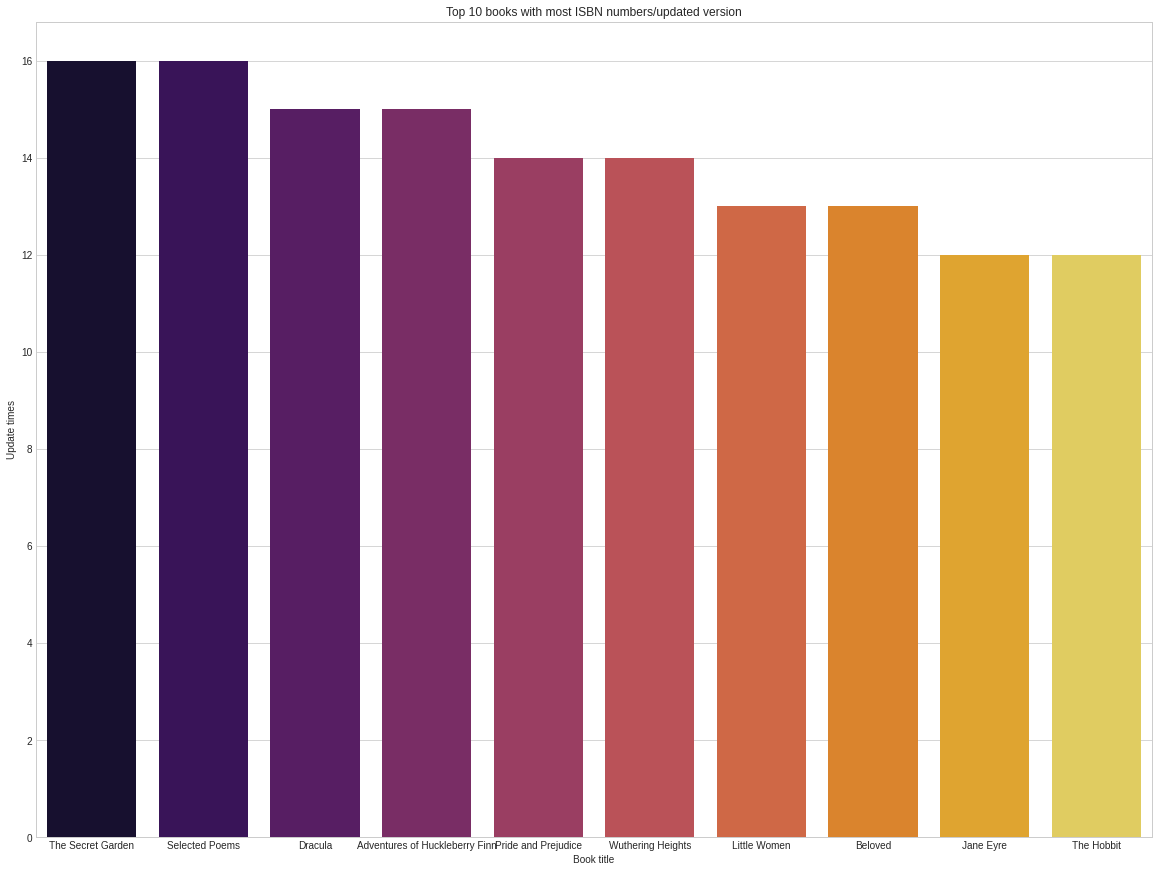

In [215]:
temp = data.groupby('book_title')['ISBN'].nunique().sort_values(ascending=False)[:10]

plt.figure(figsize=(20,15))
ax=sns.barplot(temp.index, temp.values, palette='inferno')
ax.set_title("Top 10 books with most ISBN numbers/updated version")
ax.set_xlabel("Book title")
ax.set_ylabel("Update times")

-------------

Let's also check the relation between publish year and book rating, and see if we can find something new

<Figure size 1440x1440 with 0 Axes>

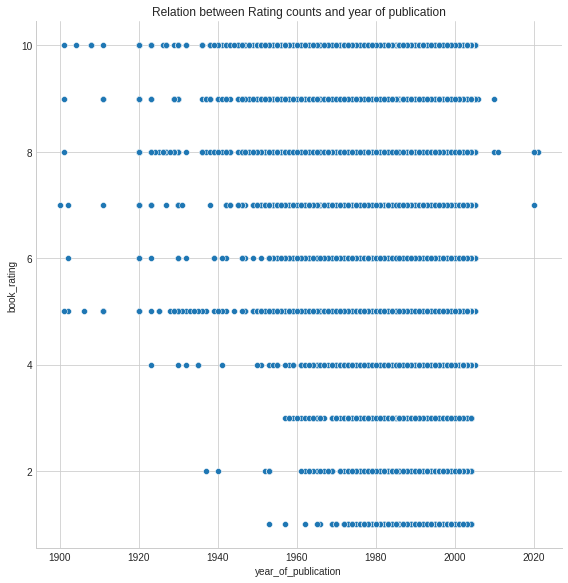

In [220]:
plt.figure(figsize=(20,20))
ax=sns.relplot(data=data, x="year_of_publication", y="book_rating",sizes=(500,200), height=8)
plt.title('Relation between Rating counts and year of publication')
ax.set_axis_labels("year_of_publication", "book_rating")

In this graph, we can tell that old books have less ratings from readers. I think it's obvious reason because old books are not that famous, compared to the new books. The books released in recent years get most popular, that people like to get more ratings. It's also indicates new books have more viewers than old books. On the other hand, new books have more criticism than old books. Some of them have very low rating scores.

## **3. Building a recommender system using collaborative filtering**

In [33]:
path = '/content/merged_data.csv'

data = pd.read_csv(path, delimiter=',', index_col=0)

In [34]:
# check the shape of dataframe
data.tail(1)

,user_id,ISBN,book_rating,Age,City,State,Country,book_title,book_author,year_of_publication,Publisher
378031,276704,0806917695,5,NaN,cedar park,texas,usa,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing


In [35]:
# check dataframe has NaN or not
data.isnull().sum()

user_id                     0
ISBN                        0
book_rating                 0
Age                    114619
City                     8435
State                     412
Country                 10350
book_title                  0
book_author                 0
year_of_publication         0
Publisher                   0
dtype: int64

Since the features 'Age', 'City', 'State' are not relevent when we do vectorization, we will drop them all. There might some information lose because of reduction; however, this lose is not that important because the recommedation system only uses book title as the input to find related books.

In [50]:
df=data.drop('Age', axis=1)
df=df.drop('City', axis=1)
df=df.drop('State', axis=1)
df.shape

(378028, 8)

In [51]:
df.isnull().sum()

user_id                    0
ISBN                       0
book_rating                0
Country                10350
book_title                 0
book_author                0
year_of_publication        0
Publisher                  0
dtype: int64

In [52]:
df = df.dropna(subset=['Country'], how='all')
df.shape

(367678, 8)

The data we have before dropping is 378028.
 The data we have after dropping is 367678. So it is not that difference.

In [53]:
df.isnull().sum()

user_id                0
ISBN                   0
book_rating            0
Country                0
book_title             0
book_author            0
year_of_publication    0
Publisher              0
dtype: int64

Filter to users in US and Canada only
> When we tried to use all the data, it always ran into memory error due to memory shortage



In [54]:
df = df[df['Country'].str.contains("usa | canada")]
df.shape

(35138, 8)

In [56]:
df_without_duplicate = df.drop_duplicates(['user_id', 'book_title'])
df_pivot = df_without_duplicate.pivot(index = 'book_title', columns = 'user_id', values = 'book_rating').fillna(0)

In [59]:
df_pivot

user_id,8,69,107,202,215,362,475,494,620,640,790,938,1048,1063,1111,1116,1123,1235,1242,1249,1259,1294,1369,1436,1439,1539,1650,1684,1721,1813,1859,1888,1901,1947,2018,2109,2116,2181,2183,2189,...,277462,277532,277538,277651,277728,277761,277794,277877,277879,277904,277929,277962,277996,278017,278019,278107,278110,278122,278148,278155,278172,278220,278221,278248,278307,278342,278357,278361,278444,278510,278541,278556,278621,278641,278672,278732,278752,278786,278846,278849
book_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nonbook Materials: The Organization of Integrated Collections,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Q-Space (Star Trek The Next Generation, Book 47)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Q-Zone (Star Trek The Next Generation, Book 48)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Summonings: Books of Magic, Vol. 2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
good girls do: Sex Chronicles of a Shameless Generation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
murder@maggody.com : An Arly Hanks Mystery (Arly Hanks Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
stardust,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply Cosine Similarity to find the distance of vectors

In [78]:
from scipy.sparse import csr_matrix
us_canada_user_rating_matrix = csr_matrix(df_pivot.values)

Use brute-force method in KNN to find the nearest neighbors

In [79]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [81]:
dist, idlist = model_knn.kneighbors(df_pivot.iloc[12,:].values.reshape(1, -1), n_neighbors = 6)

In [82]:
df_pivot.index[12]

"10,000 Dreams Interpreted or What's in a Dream"

In [73]:
dist

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.41876181, 0.41876181, 0.41876181, 0.41876181],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33563616, 1.        , 1.        , 1.        ]])

Dist = distance of vector

In [88]:
for i in range(0, len(dist.flatten())):
    if i == 0:
        print('Recommendations for: {0}:\n'.format(df_pivot.index[12]))
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, df_pivot.index[idlist.flatten()[i]], dist.flatten()[i]))

Recommendations for: 10,000 Dreams Interpreted or What's in a Dream:

1: Jitterbug Perfume, with distance of 0.6103133613206856.
2: The Mists of Avalon, with distance of 0.6301973406093434.
3: Red Dragon, with distance of 0.7516284802320576.
4: Dreamcatcher, with distance of 0.7725629279520025.
5: The Diarists Journal, with distance of 0.9004962809790011.


Try differernt distance method in KNN algorithm - Euclidean Distance

In [91]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'euclidean', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [92]:
dist, idlist = model_knn.kneighbors(df_pivot.iloc[12,:].values.reshape(1, -1), n_neighbors = 6)

In [93]:
for i in range(0, len(dist.flatten())):
    if i == 0:
        print('Recommendations for: {0}:\n'.format(df_pivot.index[12]))
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, df_pivot.index[idlist.flatten()[i]], dist.flatten()[i]))

Recommendations for: 10,000 Dreams Interpreted or What's in a Dream:

1: Old Curiosity Shop (Wordsworth Collection), with distance of 10.099504938362077.
2: Dream Giver: Following Your God-Given Destiny, with distance of 10.099504938362077.
3: Honey for a Child's Heart, with distance of 10.099504938362077.
4: Taking Chances (Heartland (Scholastic Paperback)), with distance of 10.099504938362077.
5: Darryl, with distance of 10.099504938362077.


Try differernt distance method in KNN algorithm - L1 Distance

In [94]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'l1', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='l1')

In [95]:
dist, idlist = model_knn.kneighbors(df_pivot.iloc[12,:].values.reshape(1, -1), n_neighbors = 6)

In [96]:
for i in range(0, len(dist.flatten())):
    if i == 0:
        print('Recommendations for: {0}:\n'.format(df_pivot.index[12]))
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, df_pivot.index[idlist.flatten()[i]], dist.flatten()[i]))

Recommendations for: 10,000 Dreams Interpreted or What's in a Dream:

1: No Crystal Stair, with distance of 12.0.
2: Honey for a Child's Heart, with distance of 12.0.
3: Montana'S Treasures (Desire, No 470), with distance of 12.0.
4: Silicone Solution: A Novel of Mystery and Suspense, with distance of 12.0.
5: Bombardiers : A Novel, with distance of 12.0.


## Table - result comparsion 

Book: *10,000 Dreams Interpreted or What's in a Dream*

Output from different KNN distance methods:
* Cosine similarity

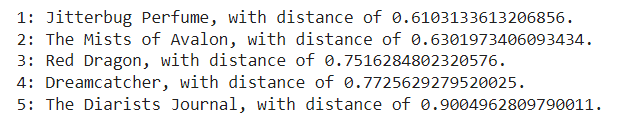

*  Eucdiean Distance
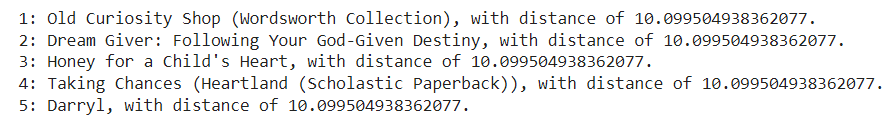


*  L1 Distance

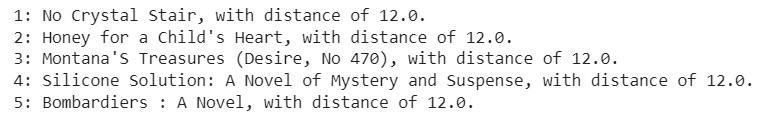

**Conclusion: The one used Cosine similarity provided the better result. The reason is that Eucdiean distance and L1 distance both do not take angle. If the data objects are far apart, they could still have a smaller angle between them. When we try to find the similar target(books), it all depends on angle of data objects. Smaller the angle, higher the similarity.**